### I. Import libraries

In [3]:
import math
import librosa
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import hmmlearn.hmm as hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.signal.windows import hann, hamming
import csv

### II. Prepare data

#### Feature extraction step-by-step

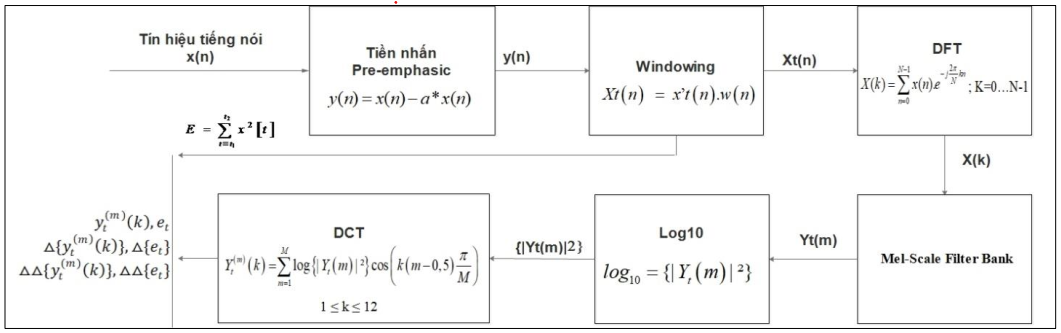

In [4]:
def feature_mfcc_extraction(signal, 
                            sr, 
                            n_mfcc, 
                            win_length_time, 
                            hop_length_time, 
                            n_fft, 
                            window_type, 
                            n_mels):

    win_length = int(win_length_time * sr)
    hop_length = int(hop_length_time * sr)
    
    mfcc = librosa.feature.mfcc(y=signal, 
                                sr=sr, 
                                n_mfcc=n_mfcc, 
                                n_fft=n_fft,
                                win_length=win_length,
                                hop_length=hop_length,
                                window=window_type,
                                n_mels=n_mels)

    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1))
    delta1_mfcc = librosa.feature.delta(mfcc, order=1)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    features_mfcc = np.concatenate([mfcc, delta1_mfcc, delta2_mfcc], axis=0)
    return features_mfcc

In [5]:
def feature_E_extraction(signal, 
                         sr, 
                         win_length_time, 
                         hop_length_time, 
                         window_type):
    
    win_length = int(win_length_time * sr)
    hop_length = int(hop_length_time * sr)
    
    frames = []
    for i in range(0, len(signal), hop_length):
        frames.append(signal[i:i + win_length])

    if len(signal) % hop_length == 0:
        frames.append(frames[-1])

    if window_type == 'hann':
        window_frames = [frame * hann(len(frame)) for frame in frames]
    elif window_type == 'hamming':
        window_frames = [frame * hamming(len(frame)) for frame in frames]
    else:
        window_frames = frames

    E = np.array([np.sum(frame ** 2) for frame in window_frames])
    delta1_E = librosa.feature.delta(E, order=1)
    delta2_E = librosa.feature.delta(E, order=2)

    return E, delta1_E, delta2_E

In [6]:
def pre_emphasis(signal, pre_emphasis_factor):
    emphasis_signal = []

    for i in range(len(signal)):
        if i > 0:
            emphasis_signal.append(signal[i] - signal[i - 1] * pre_emphasis_factor)
        else:
            emphasis_signal.append(signal[i])

    return np.array(emphasis_signal)

In [7]:
def feature_extraction(file_path, 
                       n_mfcc, 
                       win_length_time, 
                       hop_length_time, 
                       n_fft, 
                       window_type, 
                       n_mels, 
                       pre_emphasis_factor):
    
    signal, sr = librosa.load(file_path, sr=None)

    emphasis_signal = pre_emphasis(signal, pre_emphasis_factor)

    features_mfcc = feature_mfcc_extraction(emphasis_signal, 
                                            sr, 
                                            n_mfcc, 
                                            win_length_time, 
                                            hop_length_time, 
                                            n_fft, 
                                            window_type, 
                                            n_mels)
    
    features_E = feature_E_extraction(emphasis_signal, 
                                      sr, 
                                      win_length_time, 
                                      hop_length_time, 
                                      window_type)

    X = [value for value in features_mfcc]
    for value in features_E:
        X.append(value)

    return np.array(X).T

#### Get dataset

In [8]:
def get_dataset(main_dataset_path, 
                class_names, 
                test_size, 
                n_mfcc, 
                win_length_time, 
                hop_length_time, 
                n_fft, 
                window_type, 
                n_mels, 
                pre_emphasis_factor):

    all_data = {}
    all_label = {}

    for name in class_names:
        all_data[name] = []
        all_label[name] = []

    for word in os.listdir(main_dataset_path):
        word_dataset_path = os.path.join(main_dataset_path, word)

        for filename in os.listdir(word_dataset_path):
            file_path = os.path.join(word_dataset_path, filename)
            
            all_data[word].append(feature_extraction(file_path, 
                                                     n_mfcc, 
                                                     win_length_time, 
                                                     hop_length_time, 
                                                     n_fft, 
                                                     window_type, 
                                                     n_mels, 
                                                     pre_emphasis_factor))
            
            all_label[word].append(class_names.index(word))

    X = {'train': {}, 'test': {}}
    y = {'train': {}, 'test': {}}
    for cname in class_names:
        x_train, x_test, _, y_test = train_test_split(
            all_data[cname], all_label[cname], 
            test_size = test_size, 
            random_state=36
        )
        X['train'][cname] = x_train
        X['test'][cname] = x_test
        y['test'][cname] = y_test

    return X, y

#### HYPER PARAMETERS

In [ ]:
N_MFCC = 11
N_STATE = 5
N_MIX = 3

#### Extract-feature parameters

In [10]:
main_dataset_path = './signal_dataset/'
class_names = ['cothe', 'khong', 'nhung']
test_size = 0.3
win_length_time = 25e-3
hop_length_time = 10e-3
n_fft = 2048
window_type = 'hann'
n_mels = 32
pre_emphasis_factor = 0.97

In [11]:
def sr_statics():
    main_dataset_path = './signal_dataset/'

    cothe_dataset_path = os.path.join(main_dataset_path, 'cothe')
    khong_dataset_path = os.path.join(main_dataset_path, 'khong')
    nhung_dataset_path = os.path.join(main_dataset_path, 'nhung')

    cothe_file_paths = [os.path.join(cothe_dataset_path, filename) for filename in os.listdir(cothe_dataset_path)]
    khong_file_paths = [os.path.join(khong_dataset_path, filename) for filename in os.listdir(khong_dataset_path)]
    nhung_file_paths = [os.path.join(nhung_dataset_path, filename) for filename in os.listdir(nhung_dataset_path)]

    def get_signal(path):
        return librosa.load(path, sr=None)

    cothe_signals = [get_signal(path) for path in cothe_file_paths]
    khong_signals = [get_signal(path) for path in khong_file_paths]
    nhung_signals = [get_signal(path) for path in nhung_file_paths]

    sr_counts = {}

    all_signals = [cothe_signals, khong_signals, nhung_signals]
    for signals in all_signals:
        for (signal, sr) in signals:
            if sr not in sr_counts:
                sr_counts[sr] = 1
            else:
                sr_counts[sr] += 1

    plt.bar(np.arange(len(list(sr_counts.keys()))), list(sr_counts.values()))
    for i in range(len(list(sr_counts.keys()))):
        plt.text(i-0.3, list(sr_counts.values())[i]+2, s='sr = ' + str(list(sr_counts.keys())[i]))
    plt.xticks([])
    plt.title('Numbers of sample rate')
    plt.ylabel('Numbers')

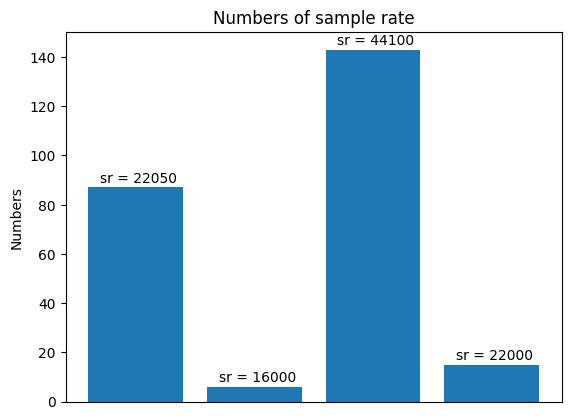

In [12]:
sr_statics()

In [13]:
X, y = get_dataset(main_dataset_path, 
                   class_names, 
                   test_size, 
                   N_MFCC, 
                   win_length_time, 
                   hop_length_time, 
                   n_fft, 
                   window_type, 
                   n_mels, 
                   pre_emphasis_factor)

([], [])

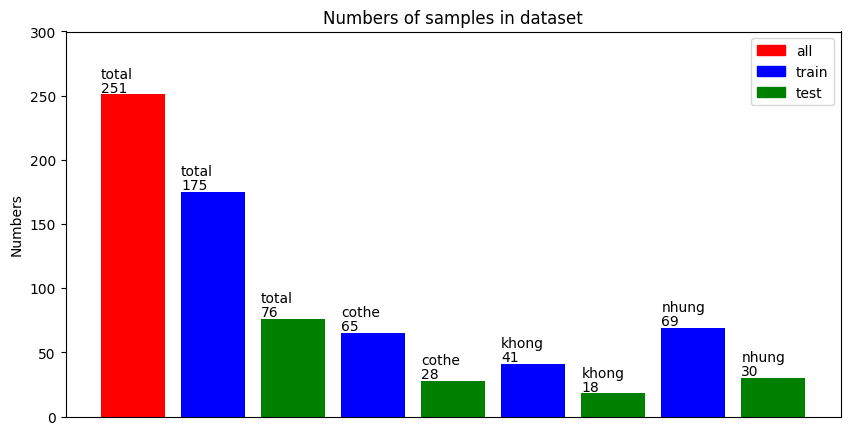

In [14]:
num_cothe_samples_train = len(X['train']['cothe'])
num_khong_samples_train = len(X['train']['khong'])
num_nhung_samples_train = len(X['train']['nhung'])
num_total_samples_train = num_cothe_samples_train + num_khong_samples_train + num_nhung_samples_train

num_cothe_samples_test = len(X['test']['cothe'])
num_khong_samples_test = len(X['test']['khong'])
num_nhung_samples_test = len(X['test']['nhung'])
num_total_samples_test = num_cothe_samples_test + num_khong_samples_test + num_nhung_samples_test

num_samples = [num_total_samples_train + num_total_samples_test,
               num_total_samples_train, 
               num_total_samples_test,
               num_cothe_samples_train,
               num_cothe_samples_test,
               num_khong_samples_train,
               num_khong_samples_test,
               num_nhung_samples_train,
               num_nhung_samples_test]

plt.figure(figsize=(10, 5))
colors = {'all':'red', 'train':'blue', 'test':'green'}     
names = ['total', 'total', 'total', 'cothe', 'cothe', 'khong', 'khong', 'nhung', 'nhung']    
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
color = ['r', 'b', 'g', 'b', 'g', 'b', 'g', 'b', 'g']
plt.bar(np.arange(len(num_samples)), num_samples, color=color)
for i in range(9):
    plt.text(i-0.4, num_samples[i]+13, names[i])
    plt.text(i-0.4, num_samples[i]+2, num_samples[i])
plt.title('Numbers of samples in dataset')
plt.ylabel('Numbers')
plt.ylim(top=300)
plt.xticks([])

### III. Training model

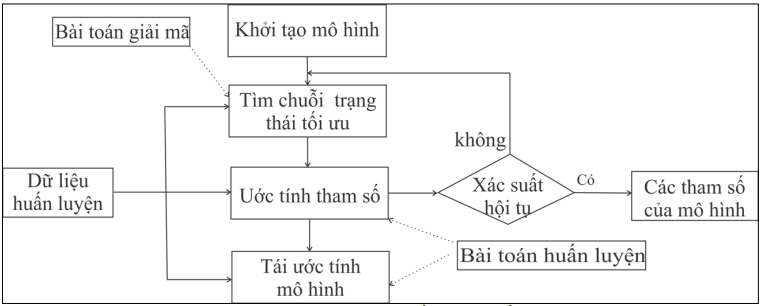

In [15]:
def training(n_state, n_mix, X):
    model = {}

    states = [n_state] * len(class_names)

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0

        model[cname] = hmm.GMMHMM(
            n_components=states[idx], 
            verbose=False, 
            n_iter=300, 
            startprob_prior=start_prob, 
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42,
            n_mix=n_mix,
        )

        model[cname].fit(X=np.vstack(X['train'][cname]), lengths=[x.shape[0] for x in X['train'][cname]])

    return model

In [16]:
model = training(N_STATE, N_MIX, X)

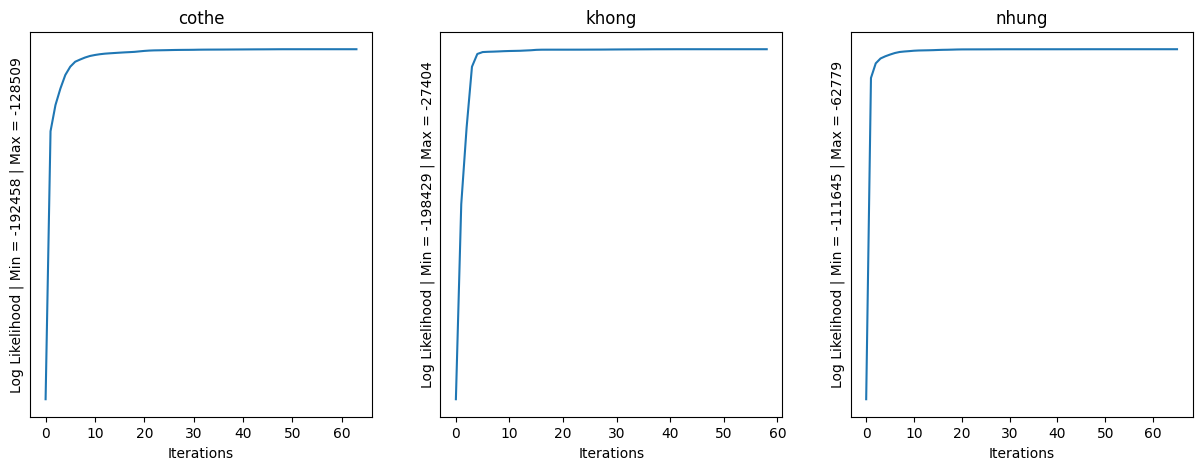

In [17]:
plt.figure(figsize=(15,5))
for i, cname in enumerate(class_names):
    plt.subplot(1, len(class_names), i+1)
    plt.plot(model[cname].monitor_.history)
    plt.ylabel(f'Log Likelihood | Min = {int(model[cname].monitor_.history[0])} | Max = {int(model[cname].monitor_.history[-1])}')
    plt.xlabel('Iterations')
    plt.title(cname)
    plt.yticks([])

### IV. Evaluating model

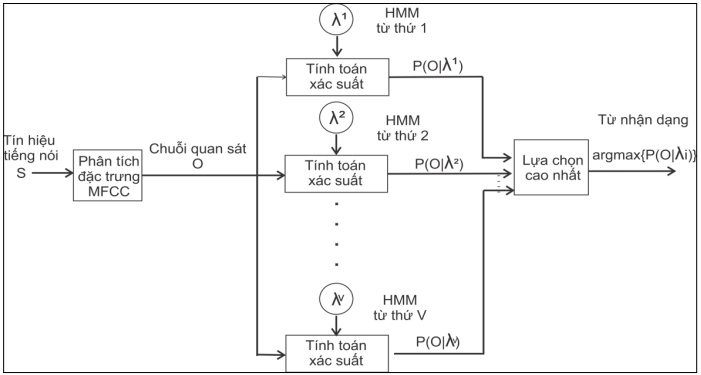

In [18]:
def evaluating(model, X, y, eval=False):

    all_pred = []
    all_true = []
    for cname in class_names:

        y_true = []
        y_pred = []

        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
                scores = [model[cname].score(mfcc) for cname in class_names]
                pred = np.argmax(scores)
                y_pred.append(pred.item())
                y_true.append(target)
        
        accuracy =(np.array(y_true) == np.array(y_pred)).sum() / len(y_true)*100
        all_true += y_true
        all_pred += y_pred

        if eval == True:
            print(f"{cname}: {'{:.4}'.format(accuracy)}%")
            print(y_true)
            print(y_pred)

    total_accuracy = (np.array(all_true) == np.array(all_pred)).sum() / len(all_true)*100

    if eval == True:
        print(f"Total: {'{:.4}'.format(total_accuracy)}%")

    return total_accuracy, all_true, all_pred

In [19]:
final_accuracy, all_true, all_pred = evaluating(model, X, y, True)

cothe: 100.0%
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
khong: 100.0%
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
nhung: 100.0%
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Total: 100.0%


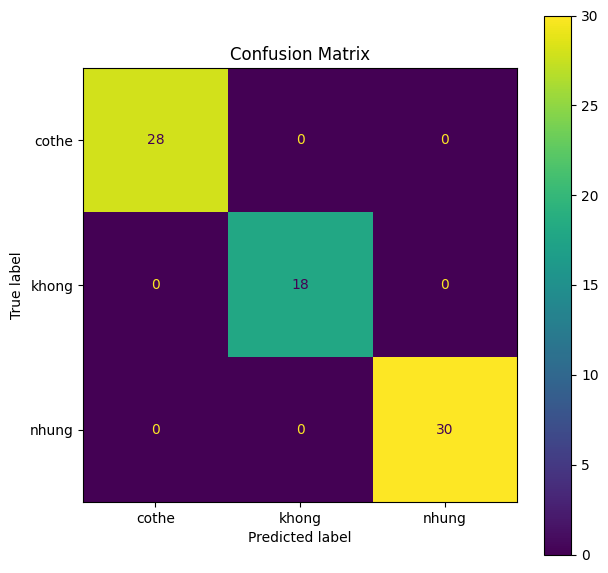

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set(title='Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_pred), display_labels=class_names).plot(ax=ax)

### V. Adjust Hyperparameters

In [21]:
def all_process(N_MFCC, N_STATE, N_MIX):
    
    X, y = get_dataset(main_dataset_path,
                       class_names,
                       test_size, 
                       N_MFCC, 
                       win_length_time, 
                       hop_length_time, 
                       n_fft, 
                       window_type, 
                       n_mels, 
                       pre_emphasis_factor)
    
    model = training(N_STATE, N_MIX, X)

    final_accuracy, _, _ = evaluating(model, X, y, False)

    return final_accuracy

In [22]:
n_mfccs = np.arange(1, 13)
n_states = np.arange(3, 8)
n_mixs = np.arange(1, 6)

In [23]:
# history = []

# print("Tuning hyperparameters process")
# print(f'{"N_MFCC":<10}{"N_STATE":<10}{"N_MIX":<10}{"Accuracy"}')
# for n_mfcc in n_mfccs:
#     for n_state in n_states:
#         for n_mix in n_mixs:
#             try:
#                 acc = all_process(n_mfcc, n_state, n_mix)
#             except:
#                 acc = 0.0
#             history.append((n_mfcc, n_state, n_mix, acc))
#             print(f'{n_mfcc:<10}{n_state:<10}{n_mix:<10}{"{:.4}".format(acc)}%')

In [24]:
with open('./result.csv', 'r') as file:
    lines = file.readlines()
    file.close()

lines = lines[1:]
lines = [line.strip() for line in lines]

In [25]:
max_percen = []
coverge = []
percens = {10:0,
           20:0,
           30:0,
           40:0,
           50:0,
           60:0,
           70:0,
           80:0,
           90:0,
           100:0}

for line in lines:
    if '100.0%' in line:
        max_percen.append(line)
    if '*' in line:
        coverge.append(line)
    percen = float(line.split(',')[3][:-1])
    if percen < 10:
        percens[10] += 1
    else:
        percens[round(int(percen), -1)] += 1

Text(0.5, 1.0, 'Histogram of percentages')

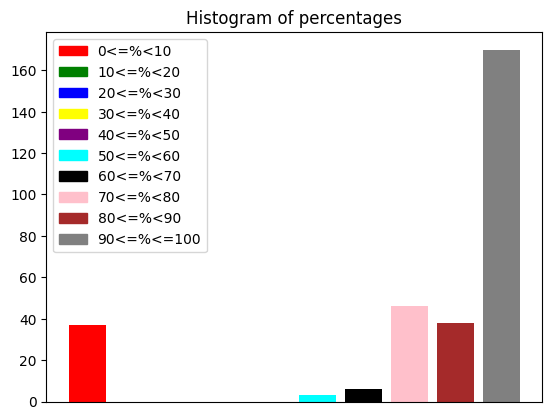

In [26]:
color = ['r', 'b', 'g', 'yellow', 'purple', 'cyan', 'black', 'pink', 'brown', 'gray']
plt.bar(np.arange(len(percens)), list(percens.values()), color=color)
plt.xticks([])
colors = {'0<=%<10':'red',
          '10<=%<20':'green',
          '20<=%<30':'blue',
          '30<=%<40':'yellow',
          '40<=%<50':'purple',
          '50<=%<60':'cyan',
          '60<=%<70':'black',
          '70<=%<80':'pink',
          '80<=%<90':'brown',
          '90<=%<=100':'gray',}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title('Histogram of percentages')

In [27]:
print(f'Total set of hyperparameters: {len(lines)}')
print(f'Numbers of set with 100%: {len(max_percen)}')
print(f'Numbers of set with converge: {len(coverge)}')

Total set of hyperparameters: 300
Numbers of set with 100%: 69
Numbers of set with converge: 10


In [28]:
best_hyper = []
for value in max_percen:
    if value in coverge:
        best_hyper.append(value)

values = best_hyper[0].split(',')
print('Best set of Hyper parameters')
print(f'N_MFCC = {values[0]}')
print(f'N_STATE = {values[1]}')
print(f'N_MIX = {values[2]}')

Best set of Hyper parameters
N_MFCC = 11
N_STATE = 5
N_MIX = 3
